# Instructions: 
##### To just produce final graph(s) as seen in the paper, run cells in "Section 1: Setup" and "Section 2: Final Graph(s)" section only, ignore the "Section 3: Simulations "
##### To run the simulations and produce your own data, run the whole notebook

### Section 1: Setup

In [1]:
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab
import scipy.linalg
import matplotlib
import csv
import random
from itertools import groupby
import collections
from scipy.special import gamma, factorial
from scipy import stats

###########################################

plt.style.use('seaborn-talk')
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['ytick.major.size'] = 10

##############################################
def migration_matrix(length, migration_rate):
    first_col = np.zeros(length)
    first_col[1] = migration_rate
    first_col[-1] = migration_rate
    result = scipy.linalg.circulant(first_col)
    return result

##############################################################
Deme_density = 50
L = 1000 #the number of demes 
deme_sample_size = Deme_density #deme sample size 
trials = 50 #number of trials
m = 0.002 #migration rate
total_sample_size = L * deme_sample_size # total sample size
matrix = migration_matrix(L, m/2)

population_configurations = L * [msprime.PopulationConfiguration(sample_size=deme_sample_size)]

print("we want 1 <<< m*deme_density <<< number of demes to keep continous structure")
print("1 <<< ",m*Deme_density," <<< ",L )
    

we want 1 <<< m*deme_density <<< number of demes to keep continous structure
1 <<<  0.1  <<<  1000


### Section 2: Simulations 

In [6]:
afs2 = []

for i in range(trials):
    ts = msprime.simulate(Ne=Deme_density, population_configurations=population_configurations, migration_matrix=matrix,record_provenance=False)

    afs1 = ts.allele_frequency_spectrum(mode="branch", polarised=True, span_normalise=False)
    
    afs2.append(afs1)
    
    #print("iteration",i)
    
afs = np.mean(afs2, 0)

In [7]:
Effective_pop = L**2 / (2 * m * np.pi**2)
print("The effective population size via Maruyama equation is: ", Effective_pop)
real_pop = L*Deme_density
print("The real population size is", real_pop)

# Since we're using branch lengths, the mutation rate is 1
Theta_eff = 4 * Effective_pop
Theta_real = 4 * real_pop


The effective population size via Maruyama equation is:  25330295.910584442
The real population size is 50000


##### Producing Bi-directional migration prediction

In [8]:
def smooth(x, threshold, rescale):
    return [np.mean(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]

transition_freq=max(Deme_density,(m*Deme_density**2))/total_sample_size


In [9]:
def smooth_sem(x, threshold, rescale):
        return [stats.sem(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]


In [10]:
thresh=1000
scale=300

In [11]:
#print(smooth_std(afs[1:], threshold=thresh, rescale=scale))

C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


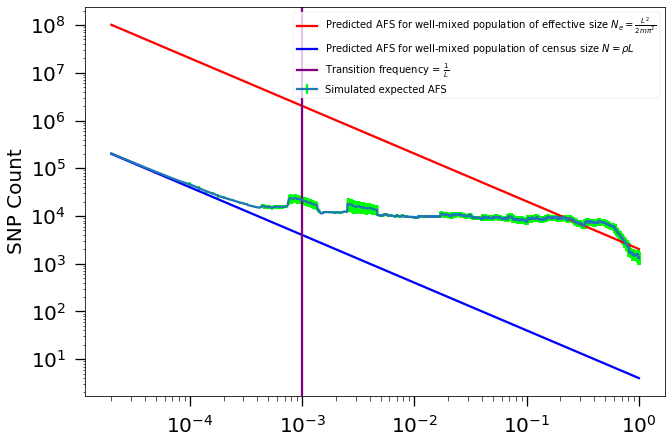

In [12]:
#err=np.array(smooth_std2(afs[1:], threshold=thresh, rescale=scale))
err=np.array(smooth_sem(afs[1:], threshold=thresh, rescale=scale))
plt.loglog(np.arange(1,total_sample_size+1)/(total_sample_size+1), Theta_eff / np.arange(1,total_sample_size+1), color="red")
plt.loglog(np.arange(1,total_sample_size+1)/(total_sample_size+1), Theta_real / np.arange(1,total_sample_size+1), color="blue")
plt.errorbar(np.arange(1, total_sample_size+1)/total_sample_size,smooth(afs[1:], threshold=thresh, rescale=scale), yerr=err, ecolor="lime")
#plt.loglog(np.arange(1, total_sample_size+1)/(total_sample_size+1),smooth(afs[1:], threshold=1000, rescale=200), color="green",linewidth=0.5) 
plt.axvline(transition_freq,color='purple')
#plt.axvline(0.2,color="orange")


plt.legend([r"Predicted AFS for well-mixed population of effective size $N_e=\frac{L^2}{2m\pi^2}$", r"Predicted AFS for well-mixed population of census size $N=\rho L$", r"Transition frequency = $\frac{1}{L}$", "Simulated expected AFS"], loc ="upper right", fontsize=10)
plt.ylabel("SNP Count")
plt.savefig("Mrholess_afs.pdf")

In [13]:
transition_freq=max(Deme_density,(m*Deme_density**2))/total_sample_size
#print(transition_freq)

In [14]:
a=[]
y=np.arange(1,total_sample_size)/total_sample_size
for i in range (len(y)):
    if np.min(y)<=y[i]<=transition_freq:
        a.append(y[i])
b=np.array(a)
#print(b)


In [15]:
x=np.array(b)*1/(np.max(b))
#print(x)
#len(x)

In [16]:
N=total_sample_size*transition_freq
u=m ## Migration rate taken as the effective mutation rate of the mutant A1 to the wild type A2
v=0 ## Mutation rate of wild type A2 to mutant A1
Beta_1=2*N*u
Beta_2=2*N*v
#print(Beta_1)
#print(Beta_2)
#print(Beta_1)

In [17]:
numerator=scipy.special.gamma(2*Beta_1+2*Beta_2)
denominator=scipy.special.gamma(2*Beta_1)*scipy.special.gamma(2*Beta_2)

gamma_coefficient=1

## Setting up the Gamma part of the equation

In [18]:
frequency_value=(x**(2*Beta_2-1))*((1-x)**(2*Beta_1-1))

## Setting up the frequency/x part of the equation
print(frequency_value)

[50.60976945 25.61989048 17.29704987 13.14126934 10.65257239  8.99765114
  7.81939034  6.93924859  6.25805223  5.71631315  5.27619159  4.91247782
  4.60773634  4.3495314   4.12876269  3.93862537  3.77393766  3.63069289
  3.50575361  3.39663796  3.30136782  3.21835915  3.14634189  3.08430101
  3.03143313  2.9871148   2.95087995  2.92240476  2.90149905  2.88810351
  2.88229317  2.88428735  2.89446774  2.9134066   2.94190881  2.98107351
  3.03238452  3.09784485  3.18018064  3.28315976  3.41210702  3.5747751
  3.78289884  4.05516547  4.42341301  4.94718533  5.75415288  7.18609199
 10.66979135         inf]


<ipython-input-18-0f5209aa8ca7>:1: RuntimeWarning: divide by zero encountered in power
  frequency_value=(x**(2*Beta_2-1))*((1-x)**(2*Beta_1-1))


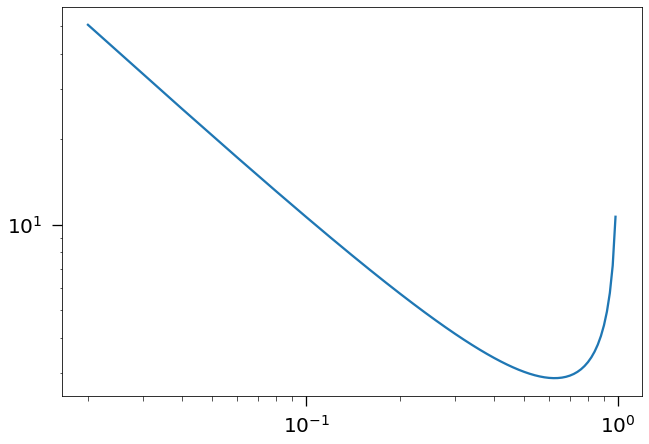

In [19]:
Effective_dist=gamma_coefficient*frequency_value
#max(Effective_dist)
plt.loglog(x,Effective_dist)

In [20]:
e=np.linspace(1/total_sample_size,transition_freq,len(x))


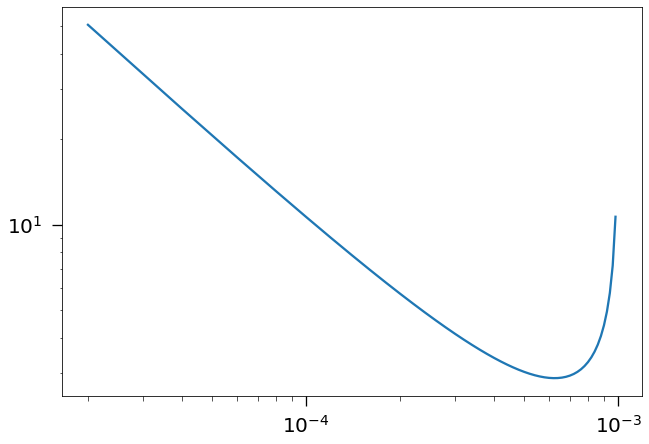

In [21]:
Effective_dist=gamma_coefficient*frequency_value
#max(Effective_dist)
plt.loglog(e,Effective_dist)

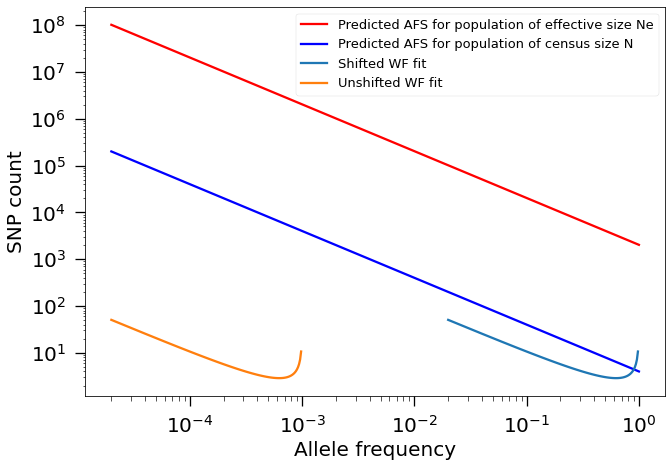

In [22]:
plt.loglog(np.arange(1,total_sample_size)/total_sample_size, Theta_eff / np.arange(1,total_sample_size), color="red")
plt.loglog(np.arange(1,total_sample_size)/total_sample_size, Theta_real / np.arange(1,total_sample_size), color="blue")
#plt.loglog(np.arange(1, total_sample_size+1)/(total_sample_size+1), smooth(afs[1:], threshold=1000, rescale=200), color="green") 
plt.loglog(x,Effective_dist)
plt.loglog(e,Effective_dist)

plt.xlabel("Allele frequency")
plt.ylabel('SNP count')
plt.legend(["Predicted AFS for population of effective size Ne", "Predicted AFS for population of census size N", "Shifted WF fit", 'Unshifted WF fit', ], loc ="upper right")
plt.savefig('Fig13.jpg')

## Even if I tried to shift it left and up, the Y axis range is far too large - I am unsure what exactly is going on

In [23]:
eff_data=Theta_real / np.arange(1,total_sample_size)
pre_factor=eff_data[0]/Effective_dist[0]

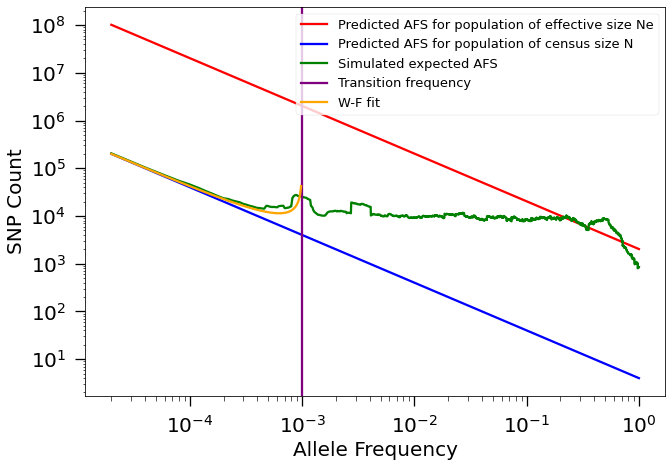

In [24]:
plt.loglog(np.arange(1,total_sample_size+1)/(total_sample_size+1), Theta_eff / np.arange(1,total_sample_size+1), color="red")
plt.loglog(np.arange(1,total_sample_size+1)/(total_sample_size+1), Theta_real / np.arange(1,total_sample_size+1), color="blue")
plt.loglog(np.arange(1, total_sample_size+1)/(total_sample_size+1),smooth(afs[1:], threshold=1000, rescale=200), color="green") 
plt.axvline(transition_freq,color='purple')
plt.loglog(e,pre_factor*Effective_dist,"orange")
#plt.axvline(0.2,color="orange")

#plt.errorbar(np.arange(1, total_sample_size+1)/total_sample_size,smooth(afs[1:], threshold=1000, rescale=200), yerr=error, ecolor="magenta")
plt.legend(["Predicted AFS for population of effective size Ne", "Predicted AFS for population of census size N", "Simulated expected AFS", 'Transition frequency', "W-F fit"], loc ="upper right")
plt.xlabel("Allele Frequency")
plt.ylabel("SNP Count")
plt.savefig('Fig14.jpg')

##### Producing voter model prediction

In [25]:
frequencies=np.arange(1, total_sample_size+1)/(total_sample_size+1)
SNPs = smooth(afs[1:], threshold=1000, rescale=200)
data_x=[]
data_y=[]
for i in range(len(frequencies)):
    if frequencies[i]>=transition_freq:
        data_x.append(frequencies[i])
        data_y.append(SNPs[i])


In [26]:
def smooth(x, threshold=100, rescale=2):
    return [np.mean(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]


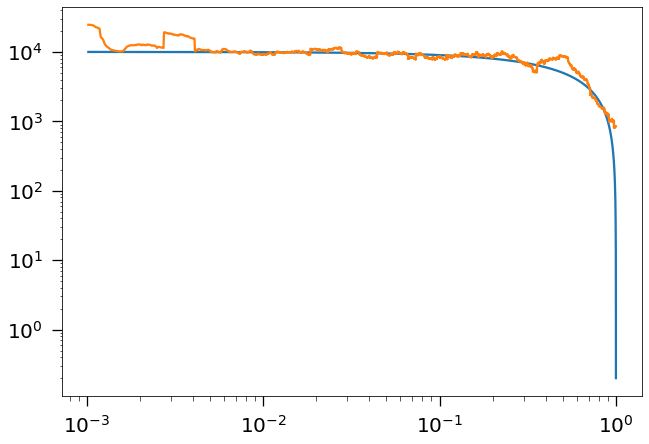

In [27]:
n=L*np.array(data_x)
u=1
fit=(u/m)*(1-(n/L))
plt.loglog(data_x,(L/Deme_density)*fit)
plt.loglog(data_x,data_y)

In [28]:
factor=L/Deme_density

In [29]:
data_y[0]/fit[0]

49.17773660959653

In [30]:
print(n)

[  1.0199796   1.0399792   1.0599788 ... 999.9400012 999.9600008
 999.9800004]


In [31]:
AF_xpoints = np.arange(1,total_sample_size+1)/(total_sample_size)
np.savetxt('AF_xpoints_mrholess.csv', AF_xpoints, delimiter=',')

Maruyama_effective_ydata = Theta_eff / np.arange(1,total_sample_size+1)
np.savetxt('Maruyama_effective_ydata_mrholess.csv', Maruyama_effective_ydata, delimiter=',')

Maruyama_census_ydata = Theta_real / np.arange(1,total_sample_size+1)
np.savetxt('Maruyama_census_ydata_mrholess.csv', Maruyama_census_ydata, delimiter=',')

Simulated_data = smooth(afs[1:], threshold=thresh, rescale=scale)
np.savetxt('Simulated_data_mrholess.csv', Simulated_data , delimiter=',')

error_data =np.array(smooth_sem(afs[1:], threshold=thresh, rescale=scale))
np.savetxt('Simulated_data_mrholess_error.csv', error_data , delimiter=',')

transition_frequency=max(Deme_density,(m*Deme_density**2))/total_sample_size


bi_directional_prediction = pre_factor*Effective_dist
np.savetxt('bi_directional_prediction_mrholess.csv', bi_directional_prediction , delimiter=',')

voter_model_prediction = factor*fit
np.savetxt('voter_model_prediction_mrholess.csv', voter_model_prediction , delimiter=',')

scaled_x_bidirection_points=e
np.savetxt('scaled_x_bidirection_points_mrholess.csv', scaled_x_bidirection_points , delimiter=',')

voter_x_data=data_x
np.savetxt('voter_x_data_mrholess.csv', voter_x_data , delimiter=',')





C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\arani\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Section 3: Final Graph(s)

In [2]:
AF_xpoints_read=np.array(pd.read_csv('AF_xpoints_mrholess.csv'))

Maruyama_effective_ydata_read= np.array(pd.read_csv('Maruyama_effective_ydata_mrholess.csv'))

Maruyama_census_ydata_read=np.array(pd.read_csv('Maruyama_census_ydata_mrholess.csv'))

Simulated_data_read = np.array(pd.read_csv('Simulated_data_mrholess.csv'))

error_data_read= np.array(pd.read_csv('Simulated_data_mrholess_error.csv'))

bi_directional_prediction_read=np.array(pd.read_csv('bi_directional_prediction_mrholess.csv'))

scaled_x_bidirection_points_read=np.array(pd.read_csv('scaled_x_bidirection_points_mrholess.csv'))

voter_model_prediction_read=np.array(pd.read_csv('voter_model_prediction_mrholess.csv'))

voter_x_data_read=np.array(pd.read_csv('voter_x_data_mrholess.csv'))


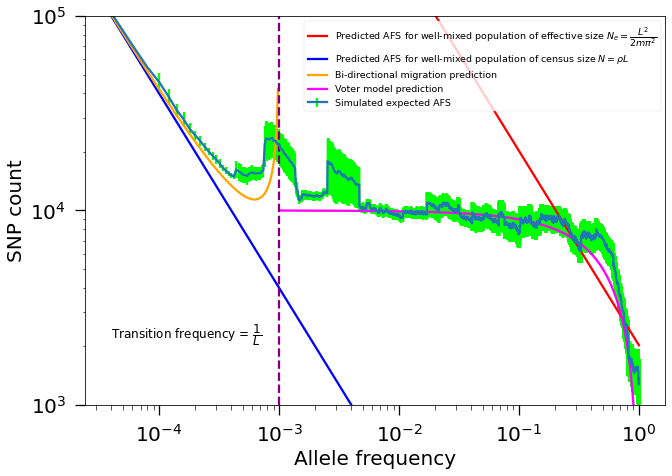

In [3]:
err=error_data_read.flatten()
transition_freq=max(Deme_density,(m*Deme_density**2))/total_sample_size
plt.loglog(AF_xpoints_read, Maruyama_effective_ydata_read, color="red", label=r"Predicted AFS for well-mixed population of effective size $N_e=\dfrac{L^2}{2m\pi^2}$")
plt.loglog(AF_xpoints_read,Maruyama_census_ydata_read, color="blue", label=r"Predicted AFS for well-mixed population of census size $N=\rho L$")
#plt.loglog(np.arange(1, total_sample_size+1)/(total_sample_size+1),smooth(afs[1:], threshold=1000, rescale=200), color="green",linewidth=0.5) 
#plt.axvline(0.2,color="orange")
plt.loglog(scaled_x_bidirection_points_read, bi_directional_prediction_read ,"orange", label='Bi-directional migration prediction')
plt.axvline(transition_freq,color='purple', linestyle = '--')
plt.text(0.00004,2200,r"Transition frequency = $\dfrac{1}{L}$",fontsize='12')
plt.loglog(voter_x_data_read,voter_model_prediction_read , color='magenta', label="Voter model prediction")
plt.errorbar(AF_xpoints_read, Simulated_data_read , yerr=err, ecolor="lime", label="Simulated expected AFS")
plt.xlabel("Allele frequency")
plt.ylabel('SNP count')
plt.legend(prop={"size":9.5},loc="upper right")
#plt.legend(["Predicted AFS for population of effective size Ne", "Predicted AFS for population of census size N", "Simulated expected AFS", 'Transition frequency', "W-F fit", "Master fit"], loc ="upper right")
#plt.legend([r"Predicted AFS for well-mixed population of effective size $N_e=\frac{L^2}{2m\pi^2}$", r"Predicted AFS for well-mixed population of census size $N=\rho L$", "W-F fit" , r"Transition frequency = $\frac{1}{L}$", "Voter fit","Simulated expected AFS"], loc ="upper right", fontsize=10)
plt.ylim(10**3, 10**5)
#plt.savefig("Fits3.pdf")